## 更新：json加入面积；文件名加前缀

In [63]:
%matplotlib inline
import json
import os
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import time
from skimage import io
import pdb
from tqdm import tqdm

In [38]:
def Img_crop_zoom(img,TL_coord,DR_coord,flag,zoom_ratio=1.4,out_size=(368,368)):  #输出 cv2 img 对象
    x_side = DR_coord[0]-TL_coord[0]
    y_side = DR_coord[1]-TL_coord[1]
    co = (zoom_ratio-1)/2.0        #coefficient 系数
    TL_x = TL_coord[0]-co*x_side
    TL_y = TL_coord[1]-co*y_side
    DR_x = DR_coord[0]+co*x_side
    DR_y = DR_coord[1]+co*y_side
    #print (img.shape)
    if  flag==1 :   #判断坐标是否越界
    
        roi = img[TL_coord[1]:DR_coord[1],TL_coord[0]:DR_coord[0]]
        #print ("越界")
    
    else:
        roi = img[TL_y:DR_y,TL_x:DR_x]   #获得ROI
    out_img = cv2.resize(roi,out_size)
    return out_img

In [51]:
def json_crop_zoom_2(img,Hands_info, zoom_ratio=1.4,out_size=(368,368)):
    x_label,y_label,check_list=zip(*Hands_info) #unzip出来是tuple形式#####################
    x_label=list(x_label)
    y_label=list(y_label)
    check_list=list(check_list)
    
    xmin,xmax = min(x_label),max(x_label)
    ymin,ymax = min(y_label),max(y_label)
    
    # 求出ROI面积
    area_ROI = (xmax-xmin)*(ymax-ymin)
    area_IMG = img.shape[0]*img.shape[1]
    area_dict = {'area_ROI':area_ROI,'ROI_ratio':area_ROI/area_IMG}
    #pdb.set_trace() 
    #初始ROI坐标（以左上角的点为(0,0)）
    x_label_new=[x-xmin for x in x_label]
    y_label_new=[x-ymin for x in y_label]
    
    #初始ROI的水平和竖直宽度
    vertical_len = ymax-ymin
    horizontal_len = xmax-xmin
    vertical_delta = (zoom_ratio-1)*vertical_len/2
    horizontal_delta = (zoom_ratio-1)*horizontal_len/2
    
    xmin_zoomed = xmin - horizontal_delta
    xmax_zoomed = xmax + horizontal_delta
    ymin_zoomed = ymin - vertical_delta
    ymax_zoomed = ymax + vertical_delta
    if ((xmin_zoomed < 0) | (ymin_zoomed < 0) | (xmax_zoomed > img.shape[1]) | (ymax_zoomed > img.shape[0]) ):   #判断坐标是否越界
        #注意：这里又忽略了“坐标”和“shape”的差异。x坐标对应的是列，即shape[1]
        FLAG_OUT_BOUND = True
        x_label_new = [x/(horizontal_len) * out_size[0] for x in x_label_new]
        y_label_new = [x/(vertical_len) * out_size[1] for x in y_label_new]
        print('越界')
        
    else:
        FLAG_OUT_BOUND = False
        #求出扩大ROI之后，每个坐标点偏移量delta

        #原始label的坐标加上水平和数值位移，再归一化，然后乘以368
        x_label_new = [(x+horizontal_delta)/(horizontal_len*zoom_ratio) * out_size[0] for x in x_label_new]
        y_label_new = [(x+vertical_delta)/(vertical_len*zoom_ratio) * out_size[1] for x in y_label_new]

    label_new=[[a,b,c] for a,b,c in zip(x_label_new,y_label_new,check_list)]
    return [xmin,ymin],[xmax,ymax],list(label_new),FLAG_OUT_BOUND,area_dict

In [52]:
def test_script(SAVE_DIR,img_name,Hands_info,VISUALIZE=True):
    img = plt.imread(img_name)
    TL_coord,DR_coord,new_label,flag,area_dict = json_crop_zoom_2(img,Hands_info)
    img_new = Img_crop_zoom(img,TL_coord,DR_coord,flag)
    if VISUALIZE:
        plt.imshow(img_new)
        for point in new_label:
            plt.plot(point[0],point[1],'r.')
    else:
        json_file_name = SAVE_DIR+'\\'+PREFIX+os.path.basename(img_name)[:-4]+'.json'
        json_dict = {'hand_pts':new_label}
        json_dict = dict(area_dict,**json_dict)
        with open(json_file_name,'w') as f:
            f.write(json.dumps(json_dict))
        #print SAVE_DIR+os.path.basename(img_name)
        io.imsave(SAVE_DIR+'\\'+PREFIX+os.path.basename(img_name),img_new)

In [61]:
%matplotlib notebook
VISUALIZE = False
TEST_DIR='D:\Dataset\hand143_panopticdb\imgs'
img_list = sorted(glob.glob(TEST_DIR+'\*jpg'))
with open('D:\Dataset\hand143_panopticdb\hands_v143_14817.json','r') as f:
    json_file = json.load(f)
SAVE_DIR='D:\Dataset\TEMP_dataset_3'
PREFIX=os.path.basename(TEST_DIR)+'_'

IND_START=0
IND_END=-1
if VISUALIZE:
    fig = plt.figure()
    for i,img_name in enumerate(img_list[IND_START:IND_END]): #使用enumerate如果iterator的索引不是从零开始，i仍然是从零开始，导致对应出错
        img_process_num = i+IND_START
        fig.clf()
        Hands_info = json_file['root'][img_process_num]['joint_self']
        test_script(SAVE_DIR,img_name,Hands_info,VISUALIZE)
        fig.canvas.draw()
        time.sleep(0.4)
else:
    for i,img_name in enumerate(img_list[IND_START:IND_END]):
        img_process_num = i+IND_START
        Hands_info = json_file['root'][img_process_num]['joint_self']
        test_script(SAVE_DIR,img_name,Hands_info,VISUALIZE)

F:\Softwares\Anaconda\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


越界


F:\Softwares\Anaconda\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界


F:\Softwares\Anaconda\lib\site-packages\skimage\io\_io.py:132: UserWarning: D:\Dataset\TEMP_dataset_3\imgs_00012555.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界
越界


测试脚本输出结果是否正确：

<IPython.core.display.Javascript object>


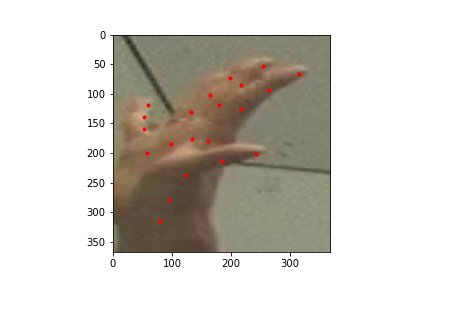

<IPython.core.display.Javascript object>


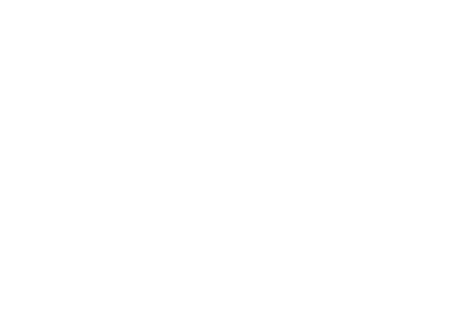

In [60]:
%matplotlib notebook
SAVE_DIR='D:\Dataset\TEMP_dataset_3/'
img_list=glob.glob(SAVE_DIR+'\*.jpg')
fig=plt.figure()
for i in range(len(img_list)):
    fig.clf()
    with open(img_list[i][:-4]+'.json','r') as f:
        tst_json=json.load(f)
    img_tst = io.imread(img_list[i])
    Hands_info=tst_json['hand_pts']
    # x_label,y_label,check_list=zip(*Hands_info) #unzip出来是tuple形式#####################
    # x_label=list(x_label)
    # y_label=list(y_label)
    plt.imshow(img_tst)
    for point in Hands_info:
        plt.plot(point[0],point[1],'r.')
    fig.canvas.draw()

In [50]:
Hands_info

[[97.05674331519513, 286.2222222222223, 1],
 [143.7764437423207, 253.4336802255206, 1],
 [204.22051372067162, 198.46970989414504, 1],
 [193.2522146158795, 133.40085951272624, 1],
 [143.7333801415952, 100.57868440934904, 1],
 [286.22222222222223, 164.3694767371012, 1],
 [226.1743373705461, 97.90672093457805, 1],
 [188.2999005324439, 113.21725849560904, 1],
 [184.17440758293841, 140.8860942539381, 1],
 [248.136773740565, 150.89381199580805, 1],
 [178.44264232637056, 81.77777777777779, 1],
 [150.8001170206542, 118.54997440959286, 1],
 [158.50850155052356, 144.82490474681737, 1],
 [199.40169679948488, 142.22020748539734, 1],
 [132.41195951085382, 85.91091288700412, 1],
 [119.5101047334857, 125.84088453445769, 1],
 [131.61958925750423, 150.10156548300884, 1],
 [148.10433561523624, 135.84112825262193, 1],
 [94.87341875841108, 106.94655260656582, 1],
 [81.77777777777777, 137.4443063374847, 1],
 [89.12873442162538, 155.83040465339224, 1]]

helper_func

In [ ]:
plt.imshow(img)
plt.plot([xmin,xmin],[ymin,ymax])
plt.plot([xmax,xmax],[ymin,ymax])
plt.plot([xmin,xmax],[ymin,ymin])
plt.plot([xmin,xmax],[ymax,ymax])
plt.show()